In [1]:
#load gamelog_data
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import json
import requests
import datetime

def season_subset(df, year_season_start, year_season_end = None):
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    if year_season_end is None:
        year_season_end = year_season_start + 1
    df_gt = df[df.GAME_DATE > datetime.date(year_season_start,9,1)]
    df_lt = df_gt[df_gt.GAME_DATE < datetime.date(year_season_end,9,1)]
    return df_lt.sort_values("GAME_DATE") if not df_lt.empty else None

In [ ]:
post85df = pd.read_csv('./gamelogs/master_post86df.csv')
post85df = post85df.drop('VIDEO_AVAILABLE',1)

In [1055]:
df85_15 = season_subset(post85df,1985,2015)

by_player = df85_15.groupby("PLAYER_NAME")

In [1056]:
df85_15["FANTASY_ZSCORE"] = by_player["FANTASY_PTS"].apply(lambda x: ((x - x.mean())/x.std()))
df85_15["i_ZSCORE_OVER"] = df85_15["FANTASY_ZSCORE"].map(lambda x: 1 if x > 1 else 0)
df85_15["SEASON_MIN"] = by_player['MIN'].apply(lambda x: x.map(lambda y: x.sum()))
df85_15["GAMES_PLAYED"] = by_player["PLAYER_NAME"].apply(lambda x: x.map(lambda y: len(x)))
for x in ['FG_PCT', 'FG3_PCT', 'FT_PCT']:
    df85_15[x] = df85_15[x].map(lambda y: 0 if np.isnan(y) else y)
df85_15["WL"] = [1 if v == "W" else 0 for v in df85_15.copy()["WL"]]

opp_home = df85_15.MATCHUP.map(lambda x: (x[-3:],0) if "@" in x else (x[-3:],1))
df85_15["OPP"] = opp_home.map(lambda x: x[0])
df85_15["i_HOME"] = opp_home.map(lambda x: x[1])

In [1057]:
#Add player bio data for age,weight,height
player_bios_df = pd.read_csv("./player_bios/player_bios.csv")
player_bios_df = player_bios_df.rename(columns = {'PERSON_ID': 'PLAYER_ID', 'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})
player_bios_df["BIRTHDATE"] = pd.to_datetime(player_bios_df["BIRTHDATE"])
player_bios_df['AGE'] = player_bios_df["BIRTHDATE"].map(lambda x: round((pd.to_datetime('today') - x).days / 365.,2))
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].astype('str')
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].astype('str')
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].map(lambda x:  float(x) if x != 'nan' else 0.)
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].map(lambda x: (12.*float(x[0]) + float(x[2:])) if x != 'nan' else 0.)

by_player = df85_15.groupby("PLAYER_NAME")

In [1058]:
def get_player_bio(name, col_name):
    return float(player_bios_df[player_bios_df.PLAYER_NAME == name][col_name])

df85_15["AGE"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"AGE")))
df85_15["WEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"WEIGHT")))
df85_15["HEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"HEIGHT")))

In [1059]:
#Integrate ELO Rankings
elo_df = pd.read_csv("./gamelogs/all_elo.csv")
elo_df["date_game"] = pd.to_datetime(elo_df["date_game"])
elo_df["game_location"] = elo_df["game_location"].map(lambda x: 1 if x == "H" else 0)
elo_df = elo_df[elo_df["is_playoffs"] == 0]

curr = elo_df.columns.tolist()
cols = [curr[i] for i in [5,8,11,13,14,17,19,21]]
elo_df = elo_df[cols]
elo_df = elo_df.rename(columns={'date_game': 'GAME_DATE',
                                'team_id':'TEAM_ABBREVIATION',
                                'opp_id':'OPP', 
                                'game_location': 'i_HOME',
                                'elo_i':'ELO',
                                'opp_elo_i': 'OPP_ELO',
                                'win_equiv': 'EXP_WINS',
                                'forecast':'FORECAST'})

elo_df['SHIT'] = elo_df['OPP_ELO'].map(lambda x: 1 if x < 1400 else 0)
elo_df['OKAY'] = elo_df['OPP_ELO'].map(lambda x: 1 if 1400 <= x < 1600 else 0)
elo_df['GOOD'] = elo_df['OPP_ELO'].map(lambda x: 1 if 1600 <= x < 1700 else 0)
elo_df['GREAT'] = elo_df['OPP_ELO'].map(lambda x: 1 if 1700 <= x else 0)

df85_15 = df85_15.merge(season_subset(elo_df,1985,2015))

In [1069]:
#Rearrange some columns in df85_15
curr = df85_15.columns.tolist()
cols = curr[:3] + curr[32:37] + curr[3:9] + curr[37:] + curr[9:32]
if len(curr) == len(cols):
    df85_15 = df85_15[cols]


name_pos = player_bios_df[["PLAYER_ID","POSITION","PLAYER_NAME"]]
df85_15 = df85_15.merge(name_pos)
df85_15["POSITION"] = df85_15.POSITION.map(lambda x: "Unknown" if pd.isnull(x) else x)
df85_15.columns.tolist()

['SEASON_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'SEASON_MIN',
 'GAMES_PLAYED',
 'OPP',
 'i_HOME',
 'AGE',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'WEIGHT',
 'HEIGHT',
 'ELO',
 'EXP_WINS',
 'OPP_ELO',
 'FORECAST',
 'SHIT',
 'OKAY',
 'GOOD',
 'GREAT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'PLUS_MINUS',
 'FANTASY_PTS',
 'FANTASY_ZSCORE',
 'i_ZSCORE_OVER',
 'POSITION']

In [8]:
def calc_season_avg(df,col_list,(date_str1,date_str2)):
    date1, date2 = pd.to_datetime(date_str1), pd.to_datetime(date_str2)
    mask = lambda x: (date1 <= x) & (x <= date2)
    return df[df.GAME_DATE.apply(mask)].groupby(["PLAYER_NAME","SEASON_ID"])[col_list].mean().reset_index()

In [9]:
def ngames_colname(col_list, ngames):
    return map(lambda x: str(ngames) + 'D_' + x, col_list)

In [10]:
def last_ngames(df,ngames,game_date,col_list):
    ngames_df = df[df.GAME_DATE < game_date].nlargest(ngames, "GAME_DATE")
    ngames_col_list = ngames_colname(col_list,ngames)
    num_cols = len(ngames_col_list)
    date_player_tuples = [("GAME_DATE",game_date)]#,("PLAYER_NAME",df.PLAYER_NAME.iloc[0])]
    if ngames_df.empty:
        return dict(date_player_tuples + zip(ngames_col_list,np.array(0).repeat(num_cols)))
    else:
        return dict(date_player_tuples + zip(ngames_col_list,ngames_df[col_list].mean()))

In [11]:
def calc_ngame_avg(df,col_list,game_date_str,ngames):
    game_date = pd.to_datetime(game_date_str)
    season_id = df[df.GAME_DATE == game_date]["SEASON_ID"].iloc[0]
    return last_ngames(df[df.SEASON_ID == season_id],ngames,game_date,col_list)

In [12]:
def rolling_cols(df,col_list,ngames,rolling_kind):
    if rolling_kind == 'mean':
        rolling_func = lambda (a,b,c): pd.rolling_mean(a,b,min_periods = c)
    elif rolling_kind == 'sum':
        rolling_func = lambda (a,b,c): pd.rolling_sum(a,b,min_periods = c)
    else:
        return None 
    
    rolling_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                    .apply(lambda x: add_game_date_pts_col(rolling_func((x[col_list],ngames,1)),x.GAME_DATE,x.FANTASY_PTS).reset_index(drop = True)))
    return rolling_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'R_' + x,col_list))))

In [13]:
def add_game_date_pts_col(df,game_date_col,fantasy_pts_col):
   new_df = pd.concat([df,game_date_col], axis = 1)
   return new_df

In [14]:
def per_season_cumsum(df,col_list):
    cumsum_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                   .apply(lambda x: add_game_date_col(x[col_list].cumsum(axis = 0), x.GAME_DATE).reset_index(drop = True)))
    return cumsum_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'C_' + x,col_list))))

In [15]:
def per_season_cummean(df,col_list):
    cumsum_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                   .apply(lambda x: add_game_date_pts_col(pd.expanding_mean(x[col_list], min_periods = 2), x.GAME_DATE, x.FANTASY_PTS).reset_index(drop = True)))
    return cumsum_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'C_' + x,col_list))))

In [16]:
def enumerate_games(df):
    new_df = df.copy()
    new_df["GAME_NUM"] = range(1,len(df.GAME_DATE) + 1)
    return new_df

def sigmoidfun(x):
	return 1/(1+np.exp(-0.007*(x-800)))

def fantasy_avg_lastn(player_df,last_n_seasons,seasons):
    return player_df[[s in seasons[-last_n_seasons:] for s in player_df.SEASON_ID]]['FANTASY_PTS'].mean()    

def true_fantasy_mean(player_df,last_n_seasons):
    seasons = list(set(player_df.SEASON_ID))
    lastn_mean = fantasy_avg_lastn(player_df,last_n_seasons,seasons)
    return player_df.groupby("SEASON_ID").apply(lambda x: x.apply(lambda y: lastn_mean + sigmoidfun(y.MIN) * (y.C_FANTASY_PTS - lastn_mean),axis = 1))

def fantasy_resp(df):
    return df.groupby('PLAYER_NAME').apply(lambda x: true_fantasy_mean(x,5))

In [976]:
df[~mask]

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,EWMA_OPP_POS,SHIT,OKAY,GOOD,GREAT,EWMA_LOG_FANTASY_PTS,FANTASY_PTS_RESP
929,22010,1717,Dirk Nowitzki,44927,1265,LAL,1,37.49,DAL,Dallas Mavericks,21000982,2011-03-12,DAL vs. LAL,0,245,84,1656.3761,55.39402,1666.0109,0.627191,37,10,19,0.526,0,2,0,5,5,1,1,9,10,6,1,2,2,3,25,1,51.5,0.965753,0,Forward,4.140771,0,0,1,0,3.672273,1


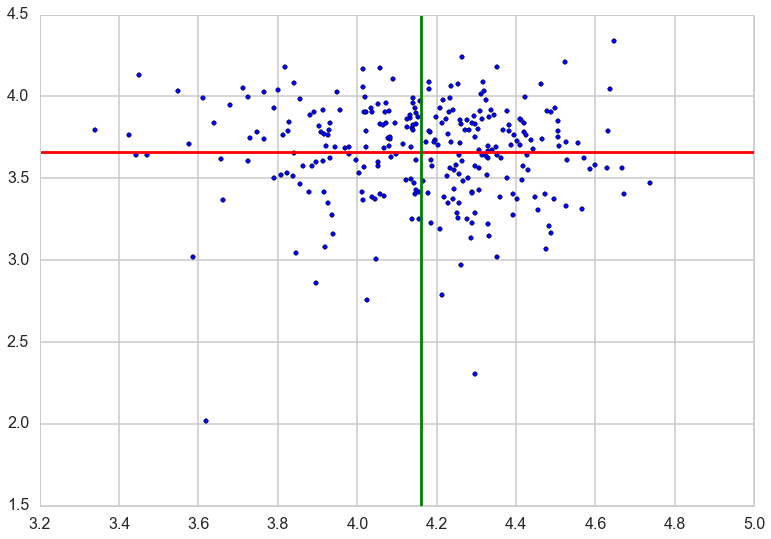

In [955]:
plt.scatter(df.EWMA_OPP_POS,np.log(df.FANTASY_PTS + 1))
plt.axhline(np.log(df.FANTASY_PTS + 1).mean(), color ='red')
plt.axvline(df.EWMA_OPP_POS.mean(), color ='green')

In [956]:
;

''

In [977]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
#train_test_split(xrange(df.shape[0]), train_size=0.7)

dftouse = df.copy()

ewma_feats = map(lambda x: 'EWMA_LOG_' + x , ewma_colfeats)
STANDARDIZABLE = ['EWMA_LOG_' + ewma_colresp, 'EWMA_OPP_POS'] + ewma_feats
for col in STANDARDIZABLE:
    print col
    valstrain=df[col].values[mask]
    valstest=df[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

lcols = STANDARDIZABLE + ["OKAY","GOOD","GREAT"]


clfsvm = LinearSVC(C=.01)
#cs=[.0001,.001,.01,.1,1,10]
#n_estimators = [1,2,10,100,500,1000]
#max_depth = [2,3,5,7,10]
pca = PCA(n_components=2)
feats = list(set(lcols) - set(['OKAY','GOOD','GREAT']))


Xmatrix=pca.fit_transform(np.array(dftouse[feats]))
Yresp=dftouse[ewma_colresp + '_RESP'].values 
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

#your code here
# from sklearn.grid_search import GridSearchCV
# #{'n_estimators':n_estimators,'max_depth':max_depth}
# gs=GridSearchCV(clfsvm, param_grid={'C':cs}, cv=5)
# gs.fit(Xmatrix_train, Yresp_train)
# print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

# #calculate the accuracy here
# best = gs.best_estimator_
# best.fit(Xmatrix_train, Yresp_train)
# best.score(Xmatrix_test, Yresp_test)
print(pca.explained_variance_ratio_)
print feats
clfsvm.fit(Xmatrix_train, Yresp_train)
clfsvm.score(Xmatrix_test, Yresp_test)

EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
[ 0.5290442  0.4709558]
['EWMA_LOG_FANTASY_PTS', 'EWMA_OPP_POS']


0.0

In [938]:
dftouse[~mask][clfsvm.predict(Xmatrix_test) == 1]['FANTASY_PTS_RESP'].mean()

0.4594594594594595

[5, 4, 3, 2, 1]

In [263]:
merged_df = pd.merge(df85_15,df85_15.groupby(["PLAYER_NAME",'OPP']).apply(lambda x: x.FANTASY_PTS).reset_index().rename(columns = {0:"FANTASY_PTS_AGAINST"}), left_on=['PLAYER_NAME','OPP'],right_on=['PLAYER_NAME','OPP'])

In [17]:
merged_df = pd.merge(df85_15,per_season_cummean(df85_15,['FANTASY_PTS']))

In [19]:
true_mean_df = merged_df.groupby(['PLAYER_NAME','SEASON_ID']).apply(lambda x: x.apply(lambda y: fantasy_avg_lastn(x,5,list(set(x.SEASON_ID))) + sigmoidfun(y.MIN) * (y.C_FANTASY_PTS - fantasy_avg_lastn(x,5,list(set(x.SEASON_ID)))), axis = 1))

TypeError: unhashable type: 'list'

In [20]:
merged_true_mean = pd.merge(df85_15,true_mean_df.reset_index().set_index('level_2'))

In [21]:
merged_true_mean = merged_true_mean.rename(columns={0:'TRUE_FANTASY_AVG'})

In [ ]:
true_mean_df85_15 = true_mean_df.reset_index().rename(columns={0:'TRUE_FANTASY_AVG'}).set_index('level_2')
del true_mean_df85_15.index.name

In [35]:
true_mean_df85_15.to_csv('./true_mean_df85_152.csv', index = False)

In [27]:
df85_15.shape

(550709, 44)

In [49]:
check_df = pd.read_csv('./true_mean_df85_152.csv')

In [1337]:
test_df = season_subset(df85_15,2006,2010)
kobe_df = test_df[test_df.PLAYER_NAME == "Rajon Rondo"]
kobe_df = kobe_df.groupby("SEASON_ID").apply(lambda x: enumerate_games(x).reset_index(drop = True)).reset_index(drop = True)

(0, 80)

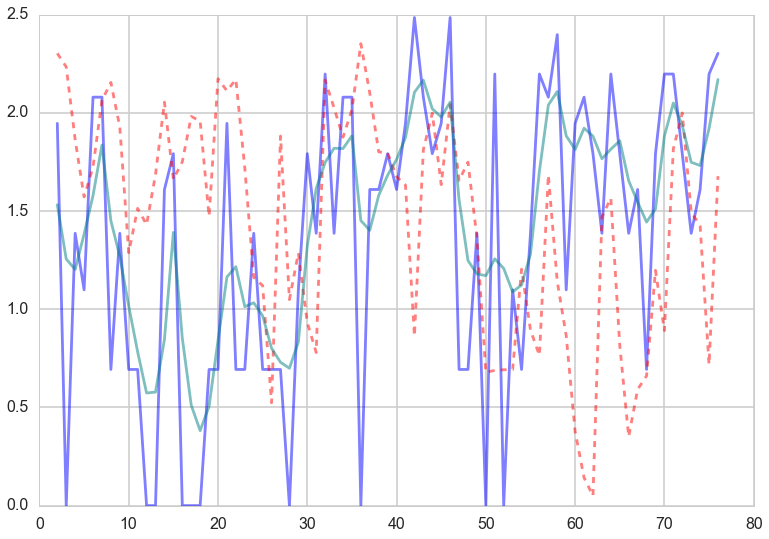

In [1339]:
fig = plt.figure()
ax = plt.axes()
season = map(lambda x: 20000 + x, [2006,2007,2008,2009])
fwd = np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'], span = 2, adjust = False).shift(1) + 1)[1:]
bwd = np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'][::-1], span = 2, adjust = False).shift(1) + 1)[1:]
c = np.vstack((fwd,bwd[::-1])).mean(axis = 0)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], np.log(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'] + 1)[1:], linestyle='-', color ='b', alpha = 0.5)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], bwd, linestyle='--', color ='r', alpha = 0.5)
#ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'][::-1], span = 2, adjust = False).shift(1)), linestyle='-', color ='teal', alpha = 0.5)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], c, linestyle='-', color ='teal', alpha = 0.5)
#ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'], np.log(pd.expanding_mean(kobe_df[kobe_df.SEASON_ID == season[0]]['AST']).shift(1)), linestyle=':', color ='g', alpha = 0.5)

#ax.plot(kobe_df[kobe_df.SEASON_ID == season[3]]['GAME_NUM'], np.log(kobe_df[kobe_df.SEASON_ID == season[3]]['PTS']), linestyle='-.', color ='k', alpha = 0.5)
ax.set_xlim(min(kobe_df['GAME_NUM']) - 1, max(kobe_df['GAME_NUM']) + 1)


In [73]:
ewma_pos = test_df.groupby(["OPP",'SEASON_ID',"POSITION"]).apply(lambda x: np.log(pd.ewma(x.PTS,span = 3).shift(1))).reset_index().rename(columns={'PTS':'EWMA_OPP_POS', 'level_3':'OLD_INDEX'}).set_index('OLD_INDEX')
cols_touse = ewma_pos.columns.difference(test_df.columns)
pd.merge(test_df,ewma_pos[cols_touse], left_index = True, right_index = True, how = 'outer')

In [327]:
days_rest = (df85_15.groupby('PLAYER_NAME')
    .apply(lambda x: pd.Series([float('nan')] + map(lambda y: (x.loc[x.index.tolist()[y+1]].GAME_DATE - x.loc[x.index.tolist()[y]].GAME_DATE).days - 1,range(x.shape[0] - 1)), index = x.index)))

In [329]:
days_rest = days_rest.reset_index(level = 0).rename(columns={0:'DAYS_REST'})

In [332]:
days_rest_df = pd.merge(df85_15, days_rest.drop('PLAYER_NAME', axis = 1), left_index = True, right_index=True)

In [334]:
days_rest_df.to_csv('./gamelogs/days_rest_df.csv', index = False)

In [340]:
store_df = []
for season in ['2' + str(year) for year in range(1996,2016)]:
    store_df.append(pd.read_csv('./defense_stats/' + season + '.csv'))
defense_df = pd.concat(store_df, axis = 0)
del store_df

In [1079]:
;

''

In [407]:
team_abbr_df = days_rest_df.groupby("TEAM_NAME").apply(lambda x: x.TEAM_ABBREVIATION.values[0]).reset_index().rename(columns={0:'TEAM_ABBR'})

In [410]:
defense_df['TEAM_ABBR'] = defense_df.TEAM_NAME.map(lambda x: team_abbr_df[team_abbr_df.TEAM_NAME == x]['TEAM_ABBR'].values)

In [409]:
team_abbr_df[team_abbr_df.TEAM_NAME == "Boston Celtics"]['TEAM_ABBR']

1    BOS
Name: TEAM_ABBR, dtype: object

In [1078]:
;

''

In [389]:
list(set(days_rest_df[days_rest_df.PLAYER_NAME == "Steve Nash"]['TEAM_NAME']))

['Dallas Mavericks', 'Los Angeles Lakers']

In [1047]:
team_abbr_df;

In [398]:
store_df = []
for i in range(6):
    store_df.append(pd.read_csv('./DKSalaries/DKSalaries' + str(i) + '.csv'))
salary_df = pd.concat(store_df,axis = 0)
opt_players = list(set(salary_df.Name))
sampled_salary = salary_df.groupby("Name").apply(lambda x: x.sample(n=1)).reset_index(drop = True)
salary_dict = dict(zip(sampled_salary.Name, sampled_salary.Salary))
salary_dict

{'Aaron Gordon': 4100,
 'Aaron Harrison': 3000,
 'Adreian Payne': 3000,
 'Al Horford': 7000,
 'Al Jefferson': 6400,
 'Al-Farouq Aminu': 6200,
 'Alan Anderson': 3000,
 'Alec Burks': 5200,
 'Alex Len': 4300,
 'Alexis Ajinca': 3500,
 'Allen Crabbe': 3300,
 'Alonzo Gee': 3000,
 "Amar'e Stoudemire": 3000,
 'Amir Johnson': 4400,
 'Anderson Varejao': 3000,
 'Andre Drummond': 9900,
 'Andre Iguodala': 5200,
 'Andre Roberson': 3000,
 'Andrea Bargnani': 3000,
 'Andrew Bogut': 4900,
 'Andrew Nicholson': 3000,
 'Andrew Wiggins': 6900,
 'Andr\xc3\xa9 Miller': 3000,
 'Anthony Bennett': 3000,
 'Anthony Brown': 3000,
 'Anthony Davis': 10700,
 'Anthony Morrow': 3100,
 'Anthony Tolliver': 3000,
 'Archie Goodwin': 3000,
 'Aron Baynes': 3000,
 'Arron Afflalo': 4300,
 'Austin Rivers': 3600,
 'Avery Bradley': 5000,
 'Ben McLemore': 3600,
 'Beno Udrih': 3000,
 'Bismack Biyombo': 3800,
 'Blake Griffin': 9500,
 'Boban Marjanovic': 3000,
 'Bojan Bogdanovic': 3300,
 'Boris Diaw': 3400,
 'Bradley Beal': 6900,
 'Br

In [399]:
singleday = df85_15[[player in salary_dict.keys() for player in  df85_15.PLAYER_NAME]][df85_15.GAME_DATE == '2014-11-13']
#singleday
singleday['REAL_POSITION'] = singleday['POSITION'].map(lambda x: x.split("-")[0])
singleday.sort_values('FANTASY_PTS', ascending = False)
np.unique(singleday['REAL_POSITION'].values)
#PG = singleday[singleday.POSITION == '']

total_players = singleday['PLAYER_NAME'].values
forwards = singleday[[pos in ["Forward"] for pos in singleday['POSITION'].values]]['PLAYER_NAME'].values
guards = singleday[[pos in ["Guard"] for pos in singleday['POSITION'].values]]['PLAYER_NAME'].values
centers = singleday[[pos in ["Center"] for pos in singleday['POSITION'].values]]['PLAYER_NAME'].values

forward = list(np.random.choice(a=forwards,replace=False,size=3))
guard = list(np.random.choice(a=guards,replace=False,size=3))
center = list(np.random.choice(a=centers,replace=False,size=1))
util = np.random.choice(a=list(set(total_players) - set(forward + guard + center)), replace = False, size = 1)

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [400]:
np.unique(singleday['TEAM_ABBREVIATION'].values)

array(['DAL', 'MEM', 'PHI', 'SAC', 'TOR'], dtype=object)

In [401]:
gafantasypts = singleday['FANTASY_PTS'].values
gaforwards = singleday['REAL_POSITION'].map(lambda x: 1 if x == 'Forward' else 0).values
gaguards = singleday['REAL_POSITION'].map(lambda x: 1 if x == 'Guard' else 0).values
gacenters = singleday['REAL_POSITION'].map(lambda x: 1 if x == 'Center' else 0).values
#gautil = np.ones(len(gacenters))
gasalaries = singleday['PLAYER_NAME'].map(lambda x: salary_dict[x]).values

In [402]:
small_data = zip(gasalaries, gafantasypts, gaforwards, gaguards, gacenters)#,gautil)
small_data

[(6900, 30.75, 1, 0, 0),
 (3000, 24.0, 0, 1, 0),
 (3100, 19.25, 1, 0, 0),
 (6200, 30.0, 1, 0, 0),
 (4900, 23.5, 0, 0, 1),
 (3000, 3.5, 1, 0, 0),
 (3200, 15.5, 0, 1, 0),
 (3700, 13.5, 0, 1, 0),
 (3600, 11.5, 1, 0, 0),
 (3000, 4.75, 0, 1, 0),
 (4300, 8.75, 0, 1, 0),
 (3100, 13.0, 1, 0, 0),
 (6300, 33.5, 0, 1, 0),
 (4400, 25.75, 1, 0, 0),
 (7100, 41.25, 1, 0, 0),
 (8500, 42.5, 0, 1, 0),
 (3200, 0.0, 0, 0, 1),
 (3200, 26.25, 1, 0, 0),
 (6300, 41.75, 0, 1, 0),
 (3000, 15.0, 1, 0, 0),
 (3500, 8.75, 0, 1, 0),
 (3000, 17.75, 1, 0, 0),
 (7300, 38.75, 0, 0, 1),
 (3800, 10.75, 0, 0, 1),
 (3700, 27.75, 0, 1, 0),
 (4700, 2.0, 1, 0, 0),
 (7200, 16.25, 0, 1, 0),
 (4700, 33.5, 0, 1, 0),
 (3100, 39.25, 1, 0, 0),
 (3000, 2.5, 1, 0, 0),
 (6200, 16.5, 1, 0, 0),
 (10800, 45.5, 1, 0, 0),
 (3700, 10.5, 0, 1, 0),
 (3000, 5.0, 1, 0, 0),
 (3500, 8.25, 1, 0, 0),
 (3300, 11.25, 1, 0, 0),
 (4100, 27.0, 1, 0, 0),
 (5600, 14.0, 1, 0, 0),
 (5700, 22.0, 0, 0, 1),
 (3100, 23.25, 1, 0, 0),
 (4900, 17.5, 0, 1, 0),
 (5900

In [412]:
from pyeasyga import pyeasyga

ga = pyeasyga.GeneticAlgorithm(small_data)        # initialise the GA with data
ga.population_size = 200000
#ga.mutation_probability = 0.05
#ga.generations = 25

# define a fitness function
def fitness(individual, data):
    salaries, points, forwards, guards, centers = 0, 0, 0, 0, 0
    for (selected, item) in zip(individual, data):
        if selected:
            salaries += item[0]
            points += item[1]
            forwards += item[2]
            guards += item[3]
            centers += item[4]
    if salaries > 50000 or ((forwards > 4) and (guards > 4)) or ((guards > 4) and (centers > 2)) or ((forwards > 4) and (centers > 2)) or ((centers + gaurds + forwards) > 8):
        points = 0
    return points

ga.fitness_function = fitness               # set the GA's fitness function
ga.run()                                    # run the GA
print ga.best_individual()                  # print the GA's best solution

(304.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


In [413]:
_,mask = ga.best_individual()
mask = np.array(mask) == 1
singleday[mask]

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,REAL_POSITION
464568,22014,200752,Rudy Gay,23437,653,MEM,0,29.32,SAC,Sacramento Kings,21400118,2014-11-13,SAC @ MEM,0,230,80,1471.6376,37.417713,1615.1119,0.197570,40,8,17,0.471,1,2,0.500,8,8,1.000,3,4,7,2,1,1,0,3,25,10,41.25,0.757644,0,Forward,Forward
465108,22014,200768,Kyle Lowry,16977,576,CHI,1,29.72,TOR,Toronto Raptors,21400119,2014-11-13,TOR vs. CHI,0,205,72,1586.3180,48.181931,1560.5881,0.673434,34,8,19,0.421,3,7,0.429,1,3,0.333,1,7,8,8,0,0,2,5,20,-4,42.50,1.098549,1,Guard,Guard
480059,22014,201148,Brandan Wright,5917,360,PHI,1,28.19,DAL,Dallas Mavericks,21400120,2014-11-13,DAL vs. PHI,1,210,82,1589.8289,50.248981,1283.3352,0.912133,16,4,7,0.571,0,0,0.000,6,7,0.857,2,3,5,0,1,2,0,3,14,16,26.25,1.204679,1,Forward,Forward
480570,22014,201144,Mike Conley,18925,581,SAC,1,28.17,MEM,Memphis Grizzlies,21400118,2014-11-13,MEM vs. SAC,1,175,73,1615.1119,52.428242,1471.6376,0.802430,39,8,17,0.471,1,3,0.333,5,6,0.833,0,1,1,11,1,0,1,4,22,13,41.75,1.320188,1,Guard,Guard
506852,22014,201954,Darren Collison,12347,421,MEM,0,28.30,SAC,Sacramento Kings,21400118,2014-11-13,SAC @ MEM,0,175,72,1471.6376,37.417713,1615.1119,0.197570,37,6,11,0.545,2,3,0.667,6,7,0.857,0,2,2,5,1,1,3,2,20,8,33.50,0.782550,0,Guard,Guard
510267,22014,201949,James Johnson,6339,341,CHI,1,28.81,TOR,Toronto Raptors,21400119,2014-11-13,TOR vs. CHI,0,250,81,1586.3180,48.181931,1560.5881,0.673434,24,7,9,0.778,0,1,0.000,2,3,0.667,2,3,5,1,4,4,1,5,16,-1,39.25,2.146544,1,Forward,Forward
518600,22014,202326,DeMarcus Cousins,10859,350,MEM,0,25.33,SAC,Sacramento Kings,21400118,2014-11-13,SAC @ MEM,0,270,83,1471.6376,37.417713,1615.1119,0.197570,31,8,17,0.471,0,0,0.000,6,7,0.857,2,10,12,1,2,3,6,5,22,19,45.50,0.425667,0,Forward-Center,Forward
545188,22014,203487,Michael Carter-Williams,4565,136,DAL,0,24.17,PHI,Philadelphia 76ers,21400120,2014-11-13,PHI @ DAL,0,190,78,1283.3352,19.652514,1589.8289,0.087867,30,6,19,0.316,1,4,0.250,6,10,0.600,3,5,8,5,0,0,6,4,19,-37,34.00,-0.157379,0,Guard,Guard


In [683]:
%connect_info

{
  "stdin_port": 49217, 
  "ip": "127.0.0.1", 
  "control_port": 49218, 
  "hb_port": 49219, 
  "signature_scheme": "hmac-sha256", 
  "key": "4f877d82-917e-4e8e-a755-e2ed24520620", 
  "shell_port": 49215, 
  "transport": "tcp", 
  "iopub_port": 49216
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-2e10449e-edff-4602-93e1-1e67277513a5.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [713]:
;

''

In [1514]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as LR
from sklearn.decomposition import PCA
#train_test_split(xrange(df.shape[0]), train_size=0.7)

def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

def run_classifier(df, mask, ewma_colresp,ewma_colfeats):
    dftouse = df.copy()

    ewma_feats = map(lambda x: 'EWMA_LOG_' + x , ewma_colfeats)
    STANDARDIZABLE = ['EWMA_LOG_' + ewma_colresp, 'EWMA_OPP_POS'] + ewma_feats
    for col in STANDARDIZABLE:
        print col
        valstrain=df[col].values[mask]
        valstest=df[col].values[~mask]
        scaler=StandardScaler().fit(valstrain)
        outtrain=scaler.transform(valstrain)
        outtest=scaler.fit_transform(valstest)
        out=np.empty(mask.shape[0])
        out[mask]=outtrain
        out[~mask]=outtest
        dftouse[col]=out

    lcols = STANDARDIZABLE + ["OKAY","GOOD","GREAT"]


    clfsvm = LR()
    #cs=[.0001,.001,.01,.1,1,10]
    #n_estimators = [1,2,10,100,500,1000]
    #max_depth = [2,3,5,7,10]
    #pca = PCA(n_components=5)
    feats = list(set(lcols) - set(['OKAY','GOOD','GREAT']))


    Xmatrix=dftouse[lcols]#pca.fit_transform(np.array(dftouse[feats]))
    Yresp=dftouse[ewma_colresp + '_RESP'].values 
    Xmatrix_train=Xmatrix[mask]
    Xmatrix_test=Xmatrix[~mask]
    Yresp_train=Yresp[mask]
    Yresp_test=Yresp[~mask]

    #your code here
    # from sklearn.grid_search import GridSearchCV
    # #{'n_estimators':n_estimators,'max_depth':max_depth}
    # gs=GridSearchCV(clfsvm, param_grid={'C':cs}, cv=5)
    # gs.fit(Xmatrix_train, Yresp_train)
    # print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

    # #calculate the accuracy here
    # best = gs.best_estimator_
    # best.fit(Xmatrix_train, Yresp_train)
    # best.score(Xmatrix_test, Yresp_test)
    print(pca.explained_variance_ratio_)
    return clfsvm, Xmatrix_train, Yresp_train, Xmatrix_test, Yresp_test

In [1515]:
def get_player_seasons(player_name, game_date,df,ewma_colresp, ewma_colfeat):
    player_df = df[df.PLAYER_NAME == player_name]
    player_df2 = pd.concat([player_df.reset_index(drop = True),player_df.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x[ewma_colresp], span = 3).shift(1) + 2.5).reset_index().drop('index',axis=1).rename(columns={ewma_colresp:'EWMA_LOG_' + ewma_colresp})).reset_index(drop = True)],axis = 1)
    for ewma_col in ewma_colfeat:
        player_df2['EWMA_LOG_' + ewma_col] = player_df2.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x[ewma_col], span = 3).shift(1) + 2.5).reset_index().drop('index',axis=1).rename(columns={ewma_col:'EWMA_LOG_' + ewma_col})).reset_index(drop = True)
    #1 if np.log(y[ewma_colresp] + 1) >= y['EWMA_LOG_' + ewma_colresp] else 0
    resp = player_df2.groupby('SEASON_ID').apply(lambda x: x.apply(lambda y: np.log(y[ewma_colresp] + 2.5), axis = 1).reset_index().drop('index',axis=1).rename(columns={0: ewma_colresp + '_RESP'})).reset_index(drop = True)
    player_df3 = pd.concat([player_df2,resp], axis = 1)
    player_df_final = player_df3.dropna()
    return player_df_final, np.array(player_df_final.GAME_DATE < game_date)

In [1510]:
def filter_players_by_season_count(df,players):
    season_count = lambda x: len(set(df[df.PLAYER_NAME == x].SEASON_ID))
    sub_players = filter(lambda x: season_count(x) >= 2, players)
    return sub_players

def reduce_picks(player_name,game_date, df, ewma_colresp, ewma_colfeats):
    seasons = list(set(df[df.PLAYER_NAME == player_name].SEASON_ID))
    season1 = seasons[1]
    dftouse,mask = get_player_seasons(player_name, game_date, df, ewma_colresp, ewma_colfeats)
    clf,xtrain,ytrain,xtest,ytest = run_classifier(dftouse,mask,ewma_colresp, ewma_colfeats)
    clf.fit(xtrain,ytrain)
    print player_name
    print 'The error is %0.2f%%' % mape(clf.predict(xtest),ytest)
    dfreturn = dftouse[~mask].copy()
    dfreturn['PRED' + ewma_colresp] = clf.predict(xtest)
    return dfreturn

def min_season(df,players):
    season = sorted(map(lambda x: df[df.PLAYER_NAME == x].SEASON_ID.min(),players))[0]
    return season

def make_ewma_pos_df(df, game_date):
    game_day_df = df[(df.GAME_DATE == game_date)]
    sub_df = df[(df.GAME_DATE <= game_date)]
    potential_players = list(set(game_day_df.PLAYER_NAME))
    players = filter_players_by_season_count(sub_df[['PLAYER_NAME','SEASON_ID']],potential_players)
    lower_bound = min_season(sub_df[['PLAYER_NAME','SEASON_ID']],players)
    sub_df2 = sub_df[sub_df.SEASON_ID >= lower_bound]
    ewma_pos = sub_df2.groupby(["OPP",'SEASON_ID',"POSITION","GAME_DATE"]).apply(lambda x: x.FANTASY_PTS.sum())
    
    ewma_pos_df_temp = (ewma_pos.reset_index().rename(columns={0:'TOT_OPP_POS'})
                                .sort_values('GAME_DATE')
                                .groupby(["OPP",'SEASON_ID',"POSITION"])
                                .apply(lambda x: 
                                    pd.DataFrame(zip(x.GAME_DATE,[-5 if np.isinf(y) else y for y in np.log(pd.ewma(x.TOT_OPP_POS, span = 3).shift(1) + 2.5)]), 
                                    index = range(x.shape[0])))
                                .rename(columns={0:'GAME_DATE',1:'EWMA_OPP_POS'})
                                .reset_index(level = [0,1,2]))
    merge_on = ['OPP','GAME_DATE','POSITION','SEASON_ID']
    ewma_pos_df = pd.merge(sub_df2,ewma_pos_df_temp,left_on=merge_on, right_on=merge_on)
    league_avg_df = (ewma_pos_df.groupby(["SEASON_ID",'POSITION'])
                     .apply(lambda x: x['EWMA_OPP_POS'].mean())
                     .reset_index()
                     .rename(columns={0:'LEAGUE_AVG_POS'}))
    nan_dict = dict(reduce(lambda x,y: x + y.items(),[{(k1,k2):v} for k1,k2,v in league_avg_df.to_records(index = False)], []))
    nan_rows = pd.isnull(ewma_pos_df['EWMA_OPP_POS'])
    ewma_pos_df.loc[nan_rows,'EWMA_OPP_POS'] = ewma_pos_df[nan_rows].apply(lambda x: nan_dict[x.SEASON_ID - 1,x.POSITION] if x.SEASON_ID > lower_bound else float('nan'), axis = 1)
    return ewma_pos_df, players

def classify_players_ondate(df,players, game_date,ewma_colresp, ewma_colfeats):
    store_df = []
    for player in players:
        print player
        store_df.append(reduce_picks(player,game_date, df, ewma_colresp, ewma_colfeats))
    return pd.concat(store_df, axis = 0)

In [1315]:
def make_player_pool(df,game_date,ewma_colresp, ewma_colfeats):
    ewma_pos_df, players = make_ewma_pos_df(df, game_date)
    return classify_players_ondate(ewma_pos_df, players,game_date,ewma_colresp,ewma_colfeats)

In [1516]:
results = make_player_pool(df85_15,'2013-03-05','FANTASY_PTS',['PTS','AST','REB','STL','BLK','TOV'])

Derek Fisher
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
EWMA_LOG_STL
EWMA_LOG_BLK
EWMA_LOG_TOV
[ 0.5290442  0.4709558]
Derek Fisher
The error is 2.23%
Ronnie Brewer
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
EWMA_LOG_STL
EWMA_LOG_BLK
EWMA_LOG_TOV
[ 0.5290442  0.4709558]
Ronnie Brewer
The error is 14.07%
Metta World Peace
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
EWMA_LOG_STL
EWMA_LOG_BLK
EWMA_LOG_TOV
[ 0.5290442  0.4709558]
Metta World Peace
The error is 4.40%
Kenneth Faried
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
EWMA_LOG_STL
EWMA_LOG_BLK
EWMA_LOG_TOV
[ 0.5290442  0.4709558]
Kenneth Faried
The error is 25.09%
Andre Miller
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWMA_LOG_REB
EWMA_LOG_STL
EWMA_LOG_BLK
EWMA_LOG_TOV
[ 0.5290442  0.4709558]
Andre Miller
The error is 1.86%
Dwight Howard
EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST
EWM

In [1448]:
results.groupby("POSITION").apply(lambda x: abs(x.FANTASY_PTS_RESP - x.PREDFANTASY_PTS).mean())

POSITION
Center            0.310865
Forward           0.411111
Forward-Center    0.149212
Forward-Guard     0.347723
Guard             0.580920
Guard-Forward     0.453248
Unknown           0.550956
dtype: float64

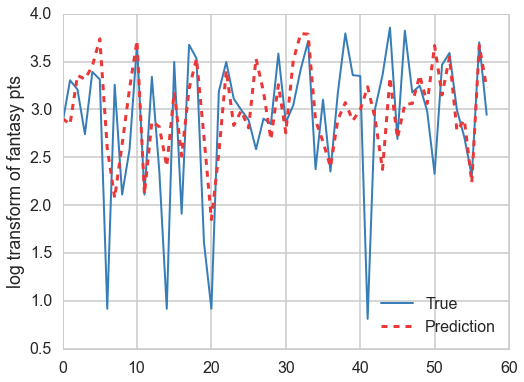

In [1422]:
plt.figure(figsize=(8,6))
plt.plot(results['FANTASY_PTS_RESP'], label='True', color='#377EB8', linewidth=2)
plt.plot(results['PREDFANTASY_PTS'], 
     '--', color='#EB3737', linewidth=3, label='Prediction')
plt.legend(loc='lower right')
plt.ylabel('log transform of fantasy pts')
plt.show()

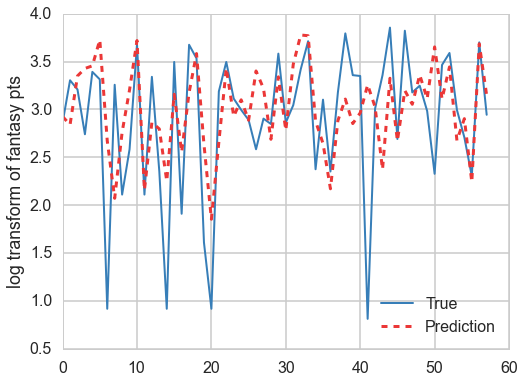

In [1502]:
plt.figure(figsize=(8,6))
plt.plot(results['FANTASY_PTS_RESP'], label='True', color='#377EB8', linewidth=2)
plt.plot(results['PREDFANTASY_PTS'], 
     '--', color='#EB3737', linewidth=3, label='Prediction')
plt.legend(loc='lower right')
plt.ylabel('log transform of fantasy pts')
plt.show()

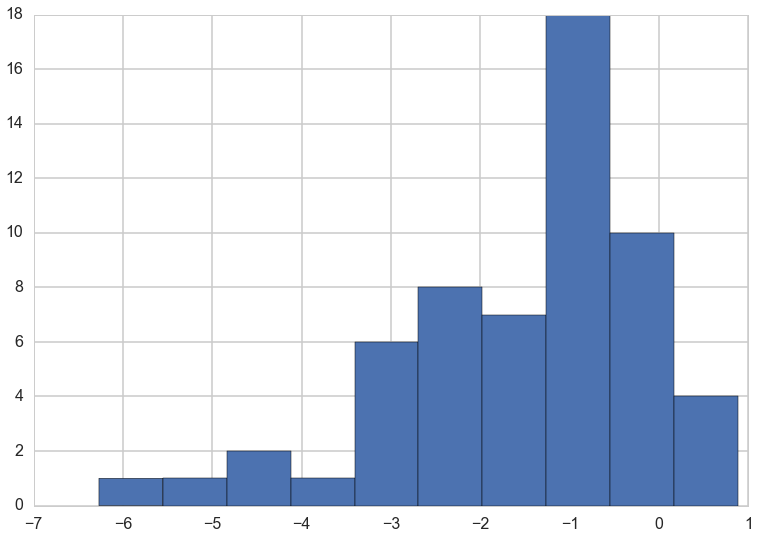

In [1439]:
np.log(results.apply(lambda x: abs(x.FANTASY_PTS_RESP - x.PREDFANTASY_PTS), axis = 1).sort_values(ascending = False)).hist()

In [1447]:
results.shape

(58, 55)

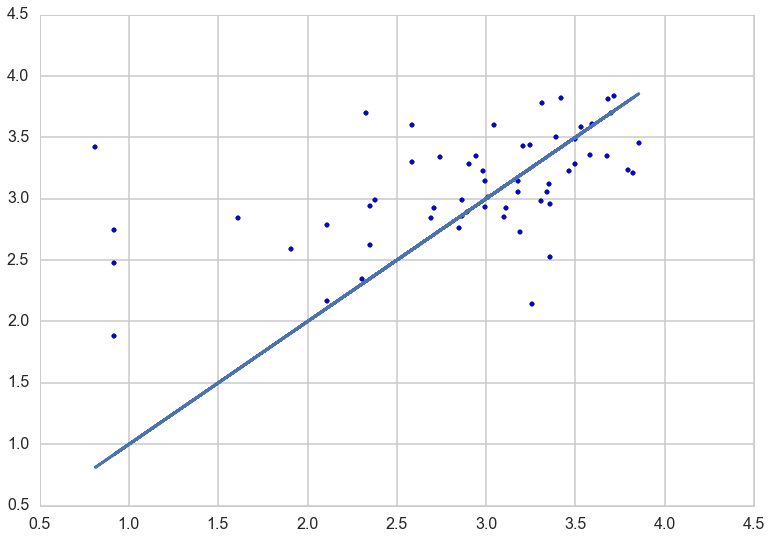

In [1452]:
plt.scatter(results.FANTASY_PTS_RESP,results.PREDFANTASY_PTS)
plt.plot(results.FANTASY_PTS_RESP,results.FANTASY_PTS_RESP)

In [1483]:
import statsmodels.api as sm

results = df85_15[df85_15.PLAYER_NAME == "Kobe Bryant"][df85_15.SEASON_ID == 22006].set_index('GAME_DATE')

In [1513]:
test = results.copy()

In [1517]:
test2 = results.copy()

In [1527]:
test3 = pd.concat([test,test2[['FANTASY_PTS_RESP','PREDFANTASY_PTS']].rename(columns={'FANTASY_PTS_RESP':'LR_FANTASY_PTS_RESP','PREDFANTASY_PTS':'LR_PREDFANTASY_PTS'})], axis = 1)

In [1546]:
test3.apply(lambda x: 1 if (x.FANTASY_PTS_RESP - x.PREDFANTASY_PTS) * (x.LR_FANTASY_PTS_RESP - x.LR_PREDFANTASY_PTS) >=0 else 0, axis = 1, raw = True)

1121    0
416     1
851     0
63      1
1067    1
656     1
37      1
462     1
207     1
90      1
1159    1
72      0
392     1
115     1
33      1
74      1
517     1
215     1
659     1
129     1
45      1
85      1
422     1
23      1
323     1
241     1
224     1
243     1
131     1
219     1
579     1
999     1
1237    1
384     1
574     1
93      1
111     1
748     1
238     1
136     1
377     1
2       1
140     0
96      1
265     1
446     1
116     1
156     1
1037    0
20      1
21      1
340     1
183     1
108     1
614     0
7       1
513     1
277     1
dtype: int64

In [1551]:
test3.loc[1037]

SEASON_ID                             22012
PLAYER_ID                              1891
PLAYER_NAME                     Jason Terry
SEASON_MIN                            38638
GAMES_PLAYED                           1213
OPP                                     PHI
i_HOME                                    0
AGE                                   38.25
TEAM_ABBREVIATION                       BOS
TEAM_NAME                    Boston Celtics
GAME_ID                            21200896
GAME_DATE               2013-03-05 00:00:00
MATCHUP                           BOS @ PHI
WL                                        1
WEIGHT                                  185
HEIGHT                                   74
ELO                                 1543.11
EXP_WINS                            45.8317
OPP_ELO                             1388.77
FORECAST                           0.577567
SHIT                                      1
OKAY                                      0
GOOD                            

In [1552]:
test3

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,SHIT,OKAY,GOOD,GREAT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,EWMA_OPP_POS,EWMA_LOG_FANTASY_PTS,EWMA_LOG_PTS,EWMA_LOG_AST,EWMA_LOG_REB,EWMA_LOG_STL,EWMA_LOG_BLK,EWMA_LOG_TOV,FANTASY_PTS_RESP,PREDFANTASY_PTS,LR_FANTASY_PTS_RESP,LR_PREDFANTASY_PTS
1121,22012,965,Derek Fisher,32722,1287,LAL,1,41.36,OKC,Oklahoma City Thunder,21200897,2013-03-05,OKC vs. LAL,1,210,73,1698.2225,60.204163,1541.7948,0.813985,0,1,0,0,18,3,4,0.750,2,2,1.000,2,2,1.000,0,0,0,0,2,0,0,1,10,3,15.00,-0.267944,0,Guard,4.504677,2.069001,1.515739,1.412226,0.979912,1.062281,0.928725,1.075373,1,0,2.862201,2.925980
416,22012,200758,Ronnie Brewer,11526,502,LAL,1,30.74,OKC,Oklahoma City Thunder,21200897,2013-03-05,OKC vs. LAL,1,235,79,1698.2225,60.204163,1541.7948,0.813985,0,1,0,0,6,0,0,0.000,0,0,0.000,0,0,0.000,0,1,1,0,1,0,1,0,0,8,2.75,-1.350807,0,Forward,4.173672,2.560019,1.667297,1.413467,1.483271,1.358331,1.011967,1.257877,1,0,3.305054,2.840087
851,22012,1897,Metta World Peace,30729,931,OKC,0,36.09,LAL,Los Angeles Lakers,21200897,2013-03-05,LAL @ OKC,0,260,79,1541.7948,44.463001,1698.2225,0.186015,0,0,1,0,33,5,11,0.455,3,6,0.500,3,4,0.750,1,2,3,1,0,0,1,4,16,-8,22.25,-0.488331,0,Forward,4.364629,3.134909,2.574427,1.307421,1.736667,1.459297,0.936619,1.279789,1,0,3.208825,3.350041
63,22012,202702,Kenneth Faried,7549,281,SAC,0,26.07,DEN,Denver Nuggets,21200898,2013-03-05,DEN @ SAC,1,228,80,1641.0487,55.197014,1384.1489,0.711604,1,0,0,0,21,9,15,0.600,0,0,0.000,1,2,0.500,3,9,12,1,1,1,1,4,19,20,39.00,1.004530,1,Forward,4.016658,3.528419,2.599287,1.544783,2.370318,1.733555,1.139014,1.243797,0,1,2.740840,3.428520
1067,22012,1889,Andre Miller,39754,1265,SAC,0,39.75,DEN,Denver Nuggets,21200898,2013-03-05,DEN @ SAC,1,200,75,1641.0487,55.197014,1384.1489,0.711604,1,0,0,0,27,8,11,0.727,0,0,0.000,0,0,0.000,1,0,1,7,0,0,1,2,16,-3,27.25,-0.151612,0,Guard,4.258767,3.347170,2.293604,2.364316,1.768674,1.351857,1.026449,1.598815,1,1,3.392829,3.455952
656,22012,2730,Dwight Howard,28717,809,OKC,0,30.02,LAL,Los Angeles Lakers,21200897,2013-03-05,LAL @ OKC,0,265,83,1541.7948,44.463001,1698.2225,0.186015,0,0,1,0,37,1,7,0.143,0,0,0.000,4,8,0.500,5,11,16,0,0,0,2,6,6,-7,25.00,-1.261564,0,Center,3.432320,3.642578,2.667518,1.106527,2.811484,1.373812,1.539975,1.839828,0,0,3.314186,3.727392
37,22012,201975,Jodie Meeks,10105,415,OKC,0,28.32,LAL,Los Angeles Lakers,21200897,2013-03-05,LAL @ OKC,0,210,76,1541.7948,44.463001,1698.2225,0.186015,0,0,1,0,21,2,6,0.333,1,3,0.333,2,2,1.000,0,1,1,0,0,0,2,1,7,-2,7.75,-0.859131,0,Guard,4.339243,1.794870,1.334876,0.919656,1.451845,0.917086,0.916311,0.934417,0,0,0.916291,2.673202
462,22012,2767,Royal Ivey,6218,492,BOS,1,33.99,PHI,Philadelphia 76ers,21200896,2013-03-05,PHI vs. BOS,0,0,0,1388.7683,28.530046,1543.1060,0.422433,0,1,0,0,37,4,9,0.444,2,7,0.286,0,0,0.000,0,2,2,3,3,0,1,3,10,8,23.50,2.555852,1,Unknown,2.962676,2.758100,2.233506,1.358130,1.566109,1.144519,0.922522,1.200181,1,0,3.258097,2.071090
207,22012,201949,James Johnson,6339,341,DEN,1,28.81,SAC,Sacramento Kings,21200898,2013-03-05,SAC vs. DEN,0,250,81,1384.1489,28.379877,1641.0487,0.288396,0,0,1,0,8,1,2,0.500,0,0,0.000,0,0,0.000,1,2,3,1,0,0,3,1,2,-3,5.75,-0.974870,0,Forward,4.222496,2.397878,1.850672,1.258665,1.309616,1.198189,1.130312,1.598561,0,0,2.110213,2.762660
90,22012,201145,Jeff Green,18103,556,PHI,0,29.30,BOS,Boston Celtics,21200896,2013-03-05,BOS @ PHI,1,235,81,1543.1060,45.831669,1388.7683,0.577567,1,0,0,0,28,4,8,0.500,1,1,1.000,7,9,0.778,2,2,4,5,1,0,1,2,16,9,30.50,0.480107,0,Forward,3.852275,3.274859,2.610970,1.348960,2.297466,1.058076,1.261946,1.683833,0,0,2.583998,3.205952


In [1553]:
%connect_info

{
  "stdin_port": 49217, 
  "ip": "127.0.0.1", 
  "control_port": 49218, 
  "hb_port": 49219, 
  "signature_scheme": "hmac-sha256", 
  "key": "4f877d82-917e-4e8e-a755-e2ed24520620", 
  "shell_port": 49215, 
  "transport": "tcp", 
  "iopub_port": 49216
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-2e10449e-edff-4602-93e1-1e67277513a5.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [1688]:
def CM_AGE(x):
    MELO_AGE = x['AGE']
    return 'AGE', MELO_AGE

def CM_MIN_PER(x):
    MIN_PER = x['MIN'] * 1.95
    return 'MELO_MIN_PER',MIN_PER

def CM_MIN_TOT(x):
    MIN_TOT = (x['MIN'] * x['GP']) * 3.35
    return 'MELO_MIN_TOT', MIN_TOT

def CM_TRUE_PER(x):
    TRUE_PER = x['TS_PCT'] * 2.8
    return 'MELO_TRUE_PER',TRUE_PER

def CM_USG_PER(x):
    USG_PER = x['USG_PCT'] * 2.8
    return 'MELO_USG_PER',USG_PER

def CM_AST_PER(x):
    AST_PER = x['AST_PCT'] * 2.25
    return 'MELO_AST_PCT', AST_PER

def CM_TO_PER(x):
    TO_PER= x['TM_TOV_PCT'] * 0.85
    return 'MELO_TO_PCT', TO_PER

def CM_REB_PER(x):
    REB_PER = x['REB_PCT'] * 2.25
    return 'MELO_REB_PCT', REB_PER

def CM_OFF_PM(x):
    OFF_PM= x['OFF_RATING'] * 1.125
    return 'OFF_PM', OFF_PM

def CM_DF_PM(x):
    DEF_PM= x['DEF_RATING'] * 1.125
    return 'DEF_PM', DEF_PM

def fab_melo(player, df):
    root = df[df.PLAYER_NAME ==
    player].sort_values('PLAYER_NAME')
    calc_melo_funcs = [CM_MIN_PER, CM_AGE, CM_MIN_TOT, CM_TRUE_PER,
    CM_USG_PER, CM_AST_PER, CM_TO_PER, CM_REB_PER, CM_OFF_PM,
    CM_DF_PM]
    result = (root.groupby('SEASON_ID').apply(lambda x:
            pd.DataFrame(dict([('SEASON_ID',x.SEASON_ID),
            ('PLAYER_NAME',x.PLAYER_NAME)] + map(lambda y: y(x),calc_melo_funcs)))))
    return result

store_df = []
melo_advanced_df = pd.read_csv("./usage_stats/master_advanced.csv") 
players = set(season_subset(df85_15,1996,2015)['PLAYER_NAME'])
for player in players:
    store_df.append(fab_melo(player,melo_advanced_df))
FAB_MELO = pd.concat(store_df,axis = 0)

In [1691]:
melo_cols = ["MELO_MIN_PER", "MELO_MIN_TOT", "DEF_PM","OFF_PM", "MELO_AST_PCT", "MELO_REB_PCT", "MELO_TO_PCT","MELO_USG_PER", "MELO_TRUE_PER"]
fab_std = FAB_MELO.groupby(["PLAYER_NAME"]).apply(lambda x: pd.Series(map(lambda y: x[y].std(), melo_cols))).reset_index().dropna().rename(columns=dict(zip(range(9),melo_cols)))

In [1692]:
fab_std

,PLAYER_NAME,MELO_MIN_PER,MELO_MIN_TOT,DEF_PM,OFF_PM,MELO_AST_PCT,MELO_REB_PCT,MELO_TO_PCT,MELO_USG_PER,MELO_TRUE_PER
0,A.C. Green,13.468135,2474.305854,6.864160,4.052655,0.028327,0.019092,1.510276,0.045088,0.083330
2,A.J. Guyton,14.467283,1173.541164,2.890907,3.770009,0.236710,0.051456,2.640934,0.158367,0.786062
3,A.J. Price,12.024192,1405.494848,4.361413,4.995135,0.064953,0.012487,1.305149,0.071203,0.090137
4,Aaron Brooks,13.887676,2901.890955,8.076025,3.206884,0.073471,0.030757,1.403144,0.077197,0.058176
5,Aaron Gordon,2.619831,1042.038515,6.363961,1.034144,0.074777,0.025456,1.682914,0.059397,0.025739
6,Aaron Gray,4.862541,609.760918,2.328971,4.221231,0.061148,0.047702,3.440388,0.093857,0.091967
7,Aaron McKie,14.599758,2696.295677,2.496016,3.363834,0.082213,0.020234,2.931901,0.132165,0.266775
9,Aaron Williams,11.575493,2212.314808,5.158623,6.006335,0.059991,0.034784,2.223174,0.080255,0.093694
11,Acie Law,6.076109,912.704780,4.847845,8.653668,0.088246,0.019213,1.039876,0.080440,0.154195
13,Adam Keefe,11.686993,1985.136057,3.218169,7.478754,0.035023,0.012984,2.969287,0.036475,0.188565


In [1737]:
fab_std_player_idx = fab_std.set_index('PLAYER_NAME')
fab_comp = pd.DataFrame(index=fab_std_player_idx.index.tolist(), columns=fab_std_player_idx.index.tolist())
fab_comp

,A.C. Green,A.J. Guyton,A.J. Price,Aaron Brooks,Aaron Gray,Aaron McKie,Aaron Williams,Acie Law,Adam Keefe,Adam Morrison,Adonal Foyle,Adrian Caldwell,Adrian Griffin,Al Harrington,Al Horford,Al Jefferson,Al Thornton,Al-Farouq Aminu,Alan Anderson,Alan Henderson,Alec Burks,Aleksandar Radojevic,Alex Acker,Alex Garcia,Alexander Johnson,Alexey Shved,Alexis Ajinca,Allan Houston,Allen Crabbe,Allen Iverson,Alonzo Gee,Alonzo Mourning,Alton Lister,Alvin Williams,Amal McCaskill,Amar'e Stoudemire,Amir Johnson,Anderson Varejao,Andrae Patterson,Andray Blatche,Andre Barrett,Andre Brown,Andre Drummond,Andre Emmett,Andre Iguodala,Andre Miller,Andre Owens,Andre Roberson,Andrea Bargnani,Andrei Kirilenko,...,Vernon Maxwell,Victor Claver,Victor Oladipo,Viktor Khryapa,Vin Baker,Vince Carter,Vincent Askew,Vinny Del Negro,Vitaly Potapenko,Vlade Divac,Vladimir Radmanovic,Vladimir Stepania,Von Wafer,Vonteego Cummings,Voshon Lenard,Wally Szczerbiak,Walt Williams,Walter Herrmann,Walter McCarty,Wang Zhi-zhi,Wayne Ellington,Wayne Simien,Wesley Johnson,Wesley Matthews,Wesley Person,Will Barton,Will Bynum,Will Conroy,Will Perdue,Will Solomon,William Avery,William Cunningham,Willie Burton,Willie Green,Wilson Chandler,Xavier Henry,Xavier McDaniel,Yakhouba Diawara,Yao Ming,Yaroslav Korolev,Yi Jianlian,Yinka Dare,Zach Randolph,Zan Tabak,Zarko Cabarkapa,Zaza Pachulia,Zeljko Rebraca,Zendon Hamilton,Zoran Planinic,Zydrunas Ilgauskas
A.C. Green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Guyton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Brooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Gray,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron McKie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [1738]:
weights = dict(zip(melo_cols,[4.5,3.0,3.0,5.0,5.0,2.5,6.0,6.0,3.5,3.5]))

In [1830]:
FAB_MELO[FAB_MELO.PLAYER_NAME == 'Trevor Ariza']

,AGE,DEF_PM,MELO_3FEQ,MELO_AST_PCT,MELO_CAREER_MIN,MELO_FT_PER,MELO_HT,MELO_MIN_PER,MELO_MIN_TOT,MELO_REB_PCT,MELO_TO_PCT,MELO_TRUE_PER,MELO_USG_PER,MELO_WT,OFF_PM,PLAYER_NAME,SEASON_ID
7757,20,0.043892,-0.802223,-0.312377,0.504463,0.020048,0.566881,-0.320936,0.137361,0.058211,-0.087991,0.006859,-0.162940,0.419418,0.156957,Trevor Ariza,22004
7758,20,-0.187367,-0.873471,-0.364697,0.504463,-0.420417,0.566881,-0.301463,-0.283071,0.695760,0.593678,-0.367472,-0.621700,0.419418,0.156957,Trevor Ariza,22005
7759,21,-0.521409,-0.887797,-0.406554,0.504463,-0.358384,0.566881,0.175621,0.020750,0.419489,0.366455,0.691350,0.066440,0.419418,-0.042039,Trevor Ariza,22006
7760,23,-0.392931,-0.391311,-0.061239,0.504463,-0.191544,0.566881,-0.486455,-0.774209,0.185721,-0.466696,0.702045,-0.621700,0.419418,0.250603,Trevor Ariza,22007
7761,24,-0.213063,0.606916,-0.260057,0.504463,0.058277,0.566881,0.370349,0.808311,0.015707,-0.485631,0.445361,-0.373205,0.419418,1.011471,Trevor Ariza,22008
7762,24,0.365086,1.063184,0.346859,0.504463,-0.222059,0.566881,1.548455,1.490574,-0.239312,-0.315214,-0.153568,0.486970,0.419418,0.426187,Trevor Ariza,22009
7763,25,0.095283,0.854040,-0.333305,0.504463,-0.003002,0.566881,1.373200,1.462836,-0.090551,-0.315214,-0.164264,-0.182055,0.419418,0.414482,Trevor Ariza,22010
7764,27,0.198065,0.105418,0.346859,0.504463,0.406700,0.566881,1.197944,0.099180,-0.111802,-0.125861,-0.068007,-0.048250,0.419418,-0.311269,Trevor Ariza,22011
7765,28,-0.534257,1.359598,0.012009,0.504463,0.775722,0.566881,0.555341,0.233957,-0.026796,0.006686,0.381190,-0.162940,0.419418,-0.276152,Trevor Ariza,22012
7766,28,-0.213063,1.647762,-0.270521,0.504463,0.339612,0.566881,1.441355,1.596960,-0.005544,-0.315214,0.937339,-0.220285,0.419418,0.484716,Trevor Ariza,22013


In [1801]:
def weight_prop(cat_str, weight_dict):
    tot = sum(weight_dict.values())
    prop = weight_dict[cat_str] / tot
    return prop

In [1800]:
def make_melo_sim(fab_std,cat_str):
    fab_std_player_idx = fab_std.set_index('PLAYER_NAME')
    fab_comp = pd.DataFrame(index=fab_std_player_idx.index.tolist(), columns=fab_std_player_idx.index.tolist())
    prop = weight_prop(cat_str, weights)
    melo_category = (fab_comp.apply(lambda x: fab_comp.columns,axis = 1)
             .apply(lambda x: fab_std_player_idx.loc[x.name][cat_str] - fab_std_player_idx.loc[x][cat_str], axis = 1)
             .applymap(lambda x: x**2 * prop))
    return melo_category

def get_top_ten(fab_std,weights,player_name):
    melo_cat_dfs = map(lambda x: make_melo_sim(fab_std,x), melo_cols)    
    fat_melo = reduce(lambda x,y: x.add(y, fill_value = 0), melo_cat_dfs,pd.DataFrame())
    return fat_melo.applymap(lambda x:(((1.25 - np.sqrt(x))/1.25)*100)).loc[player_name].sort_values(ascending = False)[:10]

In [1748]:
fat_melo.applymap(lambda x:(((1.25 - np.sqrt(x))/1.25)*100)).loc['LeBron James'].sort_values()

PLAYER_NAME
Gheorghe Muresan     -6307.070252
DeAndre Liggins      -5946.399298
Hassan Whiteside     -3903.343914
Hamady Ndiaye        -3893.628601
Bruce Bowen          -3641.367238
Paul Shirley         -3005.352564
Andrew Goudelock     -2684.749003
Dontonio Wingfield   -2608.553249
Vander Blue          -2467.088658
Ryan Humphrey        -2385.275244
Malcolm Lee          -2310.157685
Dexter Pittman       -2214.812518
Randell Jackson      -2203.665000
Marcus Williams      -2166.648498
Jamaal Franklin      -1969.299943
Will Conroy          -1943.786971
Justin Dentmon       -1929.125641
Ndudi Ebi            -1916.714643
Rodrick Rhodes       -1895.905865
Mamadou N'diaye      -1854.266123
Pavel Podkolzin      -1834.157083
Etdrick Bohannon     -1814.393370
Damone Brown         -1776.644891
Robert Covington     -1764.576105
Stojko Vrankovic     -1759.113208
Demetris Nichols     -1725.988588
Jelani McCoy         -1701.019954
Olden Polynice       -1698.943908
James Augustine      -1653.831606
Do

In [1669]:
FAB_MELO

,AGE,DEF_PM,MELO_AST_PCT,MELO_MIN_PER,MELO_MIN_TOT,MELO_REB_PCT,MELO_TO_PCT,MELO_TRUE_PER,MELO_USG_PER,OFF_PM,PLAYER_NAME,SEASON_ID
7180,27,217.2,0.700,125.65,16370.4,0.348,17.40,2.755,1.010,203.6,Rick Fox,21996
7181,28,201.2,0.620,115.50,16236.0,0.300,22.35,2.820,0.885,216.8,Rick Fox,21997
7182,29,201.0,0.640,74.90,5649.6,0.224,16.35,2.670,1.010,209.4,Rick Fox,21998
7183,30,187.0,0.576,63.00,8856.0,0.288,17.25,2.510,0.915,203.6,Rick Fox,21999
7184,31,201.6,0.672,98.00,13776.0,0.316,18.60,2.810,0.810,213.8,Rick Fox,22000
7185,32,203.2,0.696,97.65,13726.8,0.376,18.75,2.510,0.760,215.4,Rick Fox,22001
7186,33,205.0,0.684,100.45,13087.2,0.328,17.70,2.615,0.785,210.6,Rick Fox,22002
7187,34,200.2,0.644,78.05,5084.4,0.272,20.85,2.295,0.665,210.6,Rick Fox,22003
7189,38,199.0,0.196,35.35,1333.2,0.548,18.90,2.200,0.820,198.8,Rick Mahorn,21996
7190,39,196.0,0.136,42.00,4248.0,0.636,28.35,2.450,0.590,207.0,Rick Mahorn,21997


In [1671]:
fab_std

,PLAYER_NAME,SEASON_ID,MELO_MIN_PER,MELO_MIN_TOT,DEF_PM,OFF_PM,MELO_AST_PCT,MELO_REB_PCT,MELO_TO_PCT,MELO_USG_PER,MELO_TRUE_PER
1536,Chris Johnson,22012,8.167083,774.706189,25.031580,6.363961,0.048083,0.169706,2.121320,0.148492,0.318198
5678,Marcus Williams,22007,31.678384,3466.237441,18.101934,3.535534,0.401637,0.212132,15.061374,0.070711,0.880348
5679,Marcus Williams,22008,10.394470,210.859242,122.753737,56.568542,0.967322,0.098995,11.561196,0.208597,2.457196
8258,Tony Mitchell,22013,1.237437,296.560584,31.254120,31.819805,0.452548,0.280014,16.122035,0.388909,0.212132


In [1682]:
FAB_MELO.groupby(["PLAYER_NAME","SEASON_ID"]).apply(lambda x: x[melo_cols].apply(lambda y: y.std(), axis = 0))#.apply(lambda x: pd.Series(map(lambda y: x[y].std(), melo_cols))).reset_index().dropna().rename(columns=dict(zip(range(9),melo_cols)))

MELO_MIN_PER  MELO_MIN_TOT  DEF_PM  OFF_PM  MELO_AST_PCT  MELO_REB_PCT  MELO_TO_PCT  MELO_USG_PER  MELO_TRUE_PER
PLAYER_NAME        SEASON_ID                                                                                                                  
A.C. Green         21996               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   21997               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   21998               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   21999               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22000               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
A.J. Bramlett      21999               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
A.J. Guyton        22000               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22001               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22002               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
A.J. Price         22009               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22010               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22011               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22012               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22013               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22014               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
Aaron Brooks       22007               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22008               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22009               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22010               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22012               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22013               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22014               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22015               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
Aaron Gordon       22014               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22015               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
Aaron Gray         22007               NaN           NaN     NaN     NaN           NaN           NaN          NaN           NaN            NaN
                   22008  

In [1706]:
;

''